In [45]:
import tensorflow.keras
import tensorflow as tf
# from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import pyphen # used to split word into phonetic syllable. We can treat 
# the words as Italian which has strict phonetic structure 
from wordcloud import WordCloud, STOPWORDS #visualizatoin
import h5py


Preprocessing: We create wordbags from scraped web data

Split texts of chosen language into syllables using Pyphen library 

In [29]:
def PhoneticWordSplit(word):
    dic = pyphen.Pyphen(lang='it_IT')
    splitword = dic.inserted(word)
    splitword = splitword.replace("-", " ")
    return splitword

In [30]:
def WordBagMaker(corpusfilename, label):
    f = open(corpusfilename, 'r')
    lines = f.readlines()

    import random
    worddict = []
    for l in lines:
        words = l.split()
        #only words present in sentences used, not single word sentences
        if (len(words) < 2): continue 
        for w in words:
            #words with digits not used and single letter words not used
            if (len(w) > 1) and w.isalpha(): 
                worddict.append(PhoneticWordSplit(w) + " : " + label)
    #shuffle the list
    random.shuffle(worddict)   
    return worddict



In [4]:
# a helper function that writes wordbag of a given language 
def writeWordbag(corpusFilename, wordbagFilename, label):
    fl = open(wordbagFilename, "w") #create a new file and write to it
    f = open(corpusFilename, 'r')
    lines = f.readlines()
    r = WordBagMaker(corpusfilename= corpusFilename, label= label) # returns an encoding eg "ami eka : B"
    for _ in r:
        fl.write(_+"\n")
    fl.close()


In [5]:
lang = ["Korean", "Bangla"]
labelMap = {"Korean": "K", "Bangla": "B"}
for thisLang in  lang: 
    #read from corpus and create word bag 
    #! change filename from sample
    corpusFilename = f'{thisLang}Corpus.txt'
    wordbagFilename = f'{thisLang}Wordbag.txt'
    writeWordbag(corpusFilename, wordbagFilename, labelMap[thisLang])

Read data. The data read is wordbag -- not real sentences
 

In [46]:
databan = open("BanglaWordbag.txt", 'r').readlines() 
datakor = open("KoreanWordbag.txt", "r").readlines()
print(datakor[:5])

['han : K\n', 'Show : K\n', 'cant : K\n', 'deult teo : K\n', 'isun ga neul : K\n']


Bangla words mostly have 2 syllables, Korean words can have upto 5 syllables in a word. A 10 syllable vector should be enough to encode a word from either language.

TRAINING DATA

In [47]:
Ntrain = 50000
Ntest  = 10000
random.shuffle(datakor) #korean
random.shuffle(databan) #bangla
print(datakor[:5])
print(databan[:5])
TrainingVal_data = datakor[:Ntrain] + databan[:Ntrain] 
Testing_data = datakor[Ntrain:Ntrain+Ntest] + databan[Ntrain:Ntrain+Ntest]
random.shuffle(TrainingVal_data)
random.shuffle(Testing_data)


['song : K\n', 'oe chyeo b wa : K\n', 'jan so ri : K\n', 'han : K\n', 'boin da : K\n']
['ma tar : B\n', 'bis shon no : B\n', 'muk ti : B\n', 'dew : B\n', 'nea : B\n']


In [7]:
# create dataset of n word sentences 

print(Testing_data[:10])


['ma nu sh : B\n', 'oh : K\n', 'neo reul : K\n', 'she sh taa : B\n', 'ja ne : B\n', 'geu dael : K\n', 'joe nul : B\n', 'roy : B\n', 'vor : B\n', 'amar : B\n']


## Visualizations


In [8]:
def getfeatures(langcorpus):
    syllables_per_word = []
    letters_per_syllable = []
    for d in langcorpus:
        splitword = d.split(" : ")[0].split(" ")
        syllables_per_word.append(len(splitword))
        [letters_per_syllable.append(len(_)) for _ in splitword]
    return syllables_per_word, letters_per_syllable

syllables_per_wordKOR, letters_per_syllableKOR = getfeatures(datakor)

syllables_per_wordBAN, letters_per_syllableBAN = getfeatures(databan)

syllables_per_word = np.concatenate((syllables_per_wordKOR,syllables_per_wordBAN), axis=0)
letters_per_syllable = np.concatenate((letters_per_syllableKOR, letters_per_syllableBAN), axis=0)


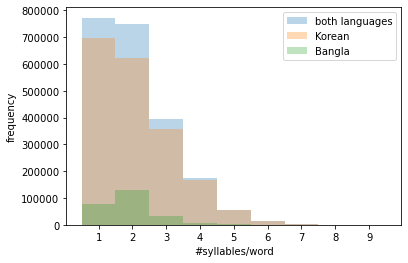

In [9]:
binsSPW = [_ - 0.5 for _ in range(1,11)]
plt.xticks(range(1,11))
plt.hist(syllables_per_word, binsSPW, alpha=0.3, label='both languages')
plt.hist(syllables_per_wordKOR, binsSPW, alpha=0.3, label='Korean') 
plt.hist(syllables_per_wordBAN, binsSPW, alpha=0.3, label='Bangla')

plt.xlabel('#syllables/word')
plt.ylabel('frequency')
plt.legend(loc='best')
plt.show()

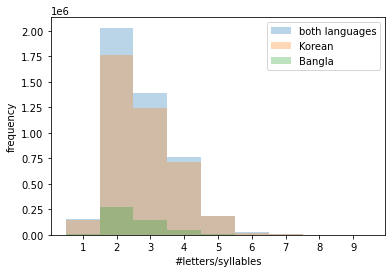

In [10]:
binsLPS = [_ - 0.5 for _ in range(1,11)]
plt.xticks(range(1,11))
plt.hist(letters_per_syllable, binsLPS, alpha=0.3, label='both languages')
plt.hist(letters_per_syllableKOR, binsLPS, alpha=0.3, label='Korean') 
plt.hist(letters_per_syllableBAN, binsLPS, alpha=0.3, label='Bangla')

plt.xlabel('#letters/syllables')
plt.ylabel('frequency')
plt.legend(loc='best')
plt.show()

## Generate Wordclouds 

In [34]:
def getCorpusString(corpus):
    corpusString = ""
    for sentence in corpus: 
        clean_sentence = sentence.replace("\n", "")
        corpusString += clean_sentence + " "
    return corpusString 


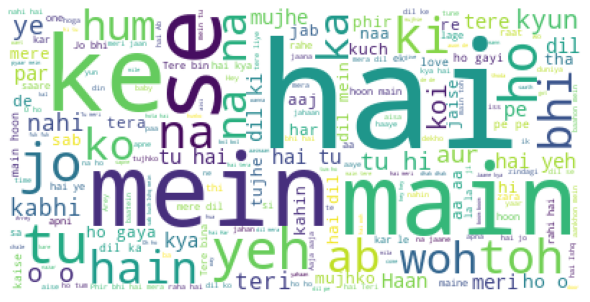

In [35]:
# for full_sentence in datakor: 
banglaCorpus = open("BanglaCorpus.txt", "r").readlines()
koreanCorpus = open("KoreanCorpus.txt", "r").readlines()

banglaString = getCorpusString(banglaCorpus)
# create wordcloud object
wc = WordCloud(background_color="white",
                max_words=200, 
                )

wc.generate(banglaString)

# generate korean wordcloud 

# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

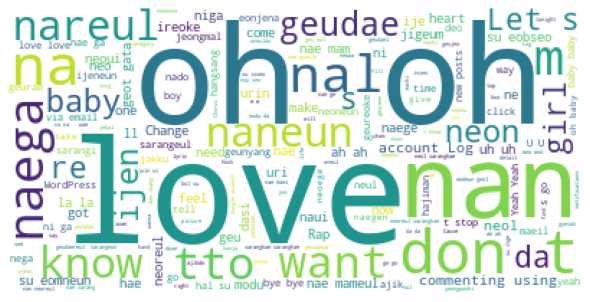

In [36]:
koreanString = getCorpusString(koreanCorpus)
# create wordcloud object
wc = WordCloud(background_color="white",
                max_words=200, 
                )

wc.generate(koreanString)

# generate korean wordcloud 

# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()


## Label Encoding

In [37]:
from keras.preprocessing.text import hashing_trick
from keras.preprocessing.sequence import pad_sequences

## Word and label encoding


In [38]:
vocab_size = 30
v = ['in in in', 'kab bo', 'so kal']
encoded_docs = [hashing_trick(d, vocab_size, hash_function='md5') for d in v]
encoded_docs
v1 = ['in in bo']
encoded_docs1 = [hashing_trick(d, vocab_size, hash_function='md5') for d in v1]
print("encoded_docs1", encoded_docs1)
print("encoded_docs",encoded_docs)

encoded_docs1 [[26, 26, 3]]
encoded_docs [[26, 26, 26], [15, 3], [26, 15]]


In [39]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.regularizers import l2

In [40]:
#returns wvec -- the bag of words and lvec -- its label in one hot vector form
def datalabel(dataset):
    '''function to label words 'K' or 'B' for Korean and Bangla resp. '''
    wvec = []
    lvec = [] 
    for td in dataset:
        if ":" in td:
            tw, tl = td.split(" : ")
            #One hot encoding: [1,0] : Bangla, [0,1] : Korean
            l = [1, 0] if tl.strip() == "B" else [0,1] #label
            wvec.append(tw)
            lvec.append(l)
    return wvec, np.array(lvec)

In [41]:
def IntEncodeWords(wordlist):
    vocab_size = 200000
    max_length = 10
    #integer encoding the syllables
    encoded_words = [hashing_trick(d, vocab_size, hash_function='md5') for d in wordlist]
    #padding to a max length of 10
    padded_words = pad_sequences(encoded_words, maxlen=max_length, padding='post')
    return padded_words

Processing the training and testing data with the above pipeline

In [42]:
#dataset are long sentences with encoding like B or K 
#ex - "Ami shikhte chai : B" -- split to "Ami shikhte, shikhte chai"
def getBigrams(dataset, lang):
    bigramSet = [] 
    for td in dataset:         
        # break sentence into two words 
        words = td.split() # should tokenize acc to whitespace 
        
        for i in range(1, len(words)): 
            bigram = words[i-1] + " "+ words[i] + " "+  f" : {lang}\n"
            bigramSet.append(bigram)
    return bigramSet

In [20]:
#create dataset of 2 word sentences 
import random
corpusfilename = "BanglaCorpus.txt"
koreanCorpusFilename = "KoreanCorpus.txt"

f = open(corpusfilename, 'r')

lines = f.readlines()
random.shuffle(lines)

print(lines[:5])
bigram_test = lines[:1000]
labelled_bigram_bangla_test = getBigrams(bigram_test, "B")

#korean 
fKor = open(koreanCorpusFilename, 'r')
linesKor = fKor.readlines()
random.shuffle(linesKor)
kor_bigram_test = linesKor[:1000]
labelled_bigram_korean_test = getBigrams(kor_bigram_test, "K")
print(labelled_bigram_bangla_test[:5], labelled_bigram_korean_test[:5])



['ekhono a jibon mane tumake buji\n', 'tumi roj bikele amar bagane\n', 'shohorer buke khoto jome ache\n', 'agun-panir golpo jome\n', 'tomake shopno dekhe dur hoto shob porajoy\n']
['ekhono a  : B\n', 'a jibon  : B\n', 'jibon mane  : B\n', 'mane tumake  : B\n', 'tumake buji  : B\n'] ['deo yoksimnaeseon  : K\n', 'yoksimnaeseon andoen  : K\n', 'andoen dahaedo  : K\n', 'All my  : K\n', 'my girls  : K\n']


In [21]:
# create bag of words of bigrams 
# create wordbag of bigrams 
#file with bigrams

fl = open("BanglaBigrams.txt","w")

for _ in labelled_bigram_bangla_test:
    if _ != "\n":
        fl.write(_)
kor_fl = open("KoreanBigrams.txt", "w")
for _ in labelled_bigram_korean_test:
    if _ != "\n":
        kor_fl.write(_)
Testing_data_bigrams = open("BanglaBigrams.txt", "r").readlines() + open("KoreanBigrams.txt", "r").readlines()
random.shuffle(Testing_data_bigrams)
print(Testing_data_bigrams[:10])
print("testing data bigram len", len(Testing_data_bigrams))


['honja uisimhago  : K\n', 'all alone  : K\n', 'korechi shob  : B\n', 'sarangeun kkeutnabeoryeotda  : K\n', 'bondhu hoye  : B\n', 'su manheun  : K\n', 'nareul badajuseyo  : K\n', 'shohider pran  : B\n', 'oerowojil ppun  : K\n', 'aami acheto  : B\n']
testing data bigram len 8094


In [43]:
#training data
wordvec, labelvec = datalabel(TrainingVal_data)
print(wordvec[:5])
print(wordvec[:3])
print(labelvec[:3])
padded_docs = IntEncodeWords(wordvec)

#testing data
print("t", Testing_data[:5])
wordvec_test, labelvec_test = datalabel(Testing_data)
# create bigram testing dataset 
# print("wordvec_test:5" , wordvec_test[:5])
# print("lavelvec_test:5", labelvec_test[:5])


['hok', 'geu reo ke', 'va bi ni', 'cha ra', 'gaai si']
['hok', 'geu reo ke', 'va bi ni']
[[1 0]
 [0 1]
 [1 0]]
t ['jak ku : K\n', 'nae mam : K\n', 'shit gu lo : B\n', 'chi ro di ner : B\n', 'LI FE : K\n']


wordvec_test, labelvec_test --> create a smaller test set with just bigrams
1. Split sentences into pairs of two words
2. Label them 
3. Test them 


In [23]:

padded_docs_test = IntEncodeWords(wordvec_test)
# print(wordvec_test[:5])
# print(padded_docs_test[:5])

# make sets for bigrams 
print(Testing_data_bigrams[:5])
wordvec_test_bigrams, labelvec_test_bigrams = datalabel(Testing_data_bigrams)
print(wordvec_test_bigrams[:5], labelvec_test_bigrams[:5])
padded_docs_test_bigrams = IntEncodeWords(wordvec_test_bigrams)


['honja uisimhago  : K\n', 'all alone  : K\n', 'korechi shob  : B\n', 'sarangeun kkeutnabeoryeotda  : K\n', 'bondhu hoye  : B\n']
['honja uisimhago ', 'all alone ', 'korechi shob ', 'sarangeun kkeutnabeoryeotda ', 'bondhu hoye '] [[0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]]


## LSTM architecture


In [24]:
lstm_out = 5
max_length = 10
print(vocab_size)
# define the model
model = Sequential()
vocab_size =200000
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(LSTM(lstm_out, recurrent_initializer="random_uniform", bias_initializer="zeros", dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dense(2, activation='softmax'))

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())


30
Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 8)             1600000   
_________________________________________________________________
lstm (LSTM)                  (None, 5)                 280       
_________________________________________________________________
dense (Dense)                (None, 2)                 12        
Total params: 1,600,292
Trainable params: 1,600,292
Non-trainable params: 0
_________________________________________________________________
None


2022-07-11 19:02:14.483347: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-11 19:02:14.484205: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [25]:
print(labelvec[:5])

[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]]


In [26]:
from keras.callbacks import EarlyStopping
class ThresholdEarlyStopping(EarlyStopping):
    def __init__(self, monitor='val_loss', min_epochs=10,
                 threshold=0.995, increase=1.75, verbose=0, mode='auto'):

        super(ThresholdEarlyStopping, self).__init__(
            monitor=monitor,
            patience=min_epochs,
            verbose=verbose,
            mode=mode
        )

        self.threshold = threshold
        self.increase = increase

    def on_epoch_end(self, epoch, logs={}):
        if epoch < self.patience:
            current = logs.get(self.monitor)
            if current is None:
                warnings.warn('Early stopping requires %s to be available!'
                              % (self.monitor), RuntimeWarning)

            if self.monitor_op(current, self.best):
                # if current val_loss within 0.5% margin of the best(min) val_loss, 
                # add some grace to the patience to monitor if val_loss is indeed converging 
                if self.monitor_op(current, self.threshold*self.best):
                    self.patience = max(self.patience, epoch*self.increase)
                self.best = current

        else:
            if self.verbose > 0:
                print('Epoch %05d: early stopping' % (epoch))

            self.model.stop_training = True

In [27]:
print(labelvec[:5])

[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]]


In [28]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)


In [29]:
history = model.fit(padded_docs, labelvec, batch_size=2000, validation_split=0.1, epochs=500, verbose=1, callbacks=[ThresholdEarlyStopping(verbose=1, min_epochs=50)])
# history = model.fit(padded_docs, labelvec, batch_size=2000, validation_split=0.1, epochs=500, verbose=1,)

2022-07-11 19:02:25.293356: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-11 19:02:25.296406: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/500


2022-07-11 19:02:37.052853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


45/45 [==============================] - ETA: 0s - loss: 0.8465 - accuracy: 0.5098

2022-07-11 19:02:47.810244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


45/45 [==============================] - 23s 236ms/step - loss: 0.8463 - accuracy: 0.5100 - val_loss: 0.8198 - val_accuracy: 0.4946
Epoch 2/500
45/45 [==============================] - 9s 205ms/step - loss: 0.8118 - accuracy: 0.5878 - val_loss: 0.7885 - val_accuracy: 0.7063
Epoch 3/500
45/45 [==============================] - 9s 197ms/step - loss: 0.7786 - accuracy: 0.7087 - val_loss: 0.7271 - val_accuracy: 0.8534
Epoch 4/500
45/45 [==============================] - 9s 196ms/step - loss: 0.6723 - accuracy: 0.8057 - val_loss: 0.4596 - val_accuracy: 0.8877
Epoch 5/500
45/45 [==============================] - 9s 203ms/step - loss: 0.4543 - accuracy: 0.8900 - val_loss: 0.3721 - val_accuracy: 0.9058
Epoch 6/500
45/45 [==============================] - 9s 206ms/step - loss: 0.3859 - accuracy: 0.9150 - val_loss: 0.3441 - val_accuracy: 0.9146
Epoch 7/500
45/45 [==============================] - 10s 215ms/step - loss: 0.3529 - accuracy: 0.9245 - val_loss: 0.3266 - val_accuracy: 0.9199
Epoch 8/5

In [17]:
print(padded_docs_test[:5])

[[159716 161481      0      0      0      0      0      0      0      0]
 [  6294  85094  55553  88606      0      0      0      0      0      0]
 [ 69092 155075 183478      0      0      0      0      0      0      0]
 [ 51674  59797  14065      0      0      0      0      0      0      0]
 [ 14172      0      0      0      0      0      0      0      0      0]]


## Save the model


In [42]:
from keras.models import model_from_json
print(model.summary())
#model to json
model_json = model.to_json()
print(model_json)
json_file = open("translit.json", "w")
json_file.write(model_json)
#weights to h5
model.save_weights("translit.h5")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 8)             1600000   
_________________________________________________________________
lstm (LSTM)                  (None, 5)                 280       
_________________________________________________________________
dense (Dense)                (None, 2)                 12        
Total params: 1,600,292
Trainable params: 1,600,292
Non-trainable params: 0
_________________________________________________________________
None
{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 10], "dtype": "float32", "sparse": false, "ragged": false, "name": "embedding_input"}}, {"class_name": "Embedding", "config": {"name": "embedding", "trainable": true, "batch_input_shape": [null, 10], "dtype": "float32", "input_dim

2022-07-11 19:46:34.652259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Accuracy: 92.46 %


In [4]:
from keras.models import model_from_json

# load model
jfile = open('translit.json', 'r')
loaded_model_json = jfile.read()
jfile.close()
# print("load mdoel", loaded_model_json)

loaded_model = model_from_json(loaded_model_json)
# load weights
loaded_model.load_weights("translit.h5")
# print("Loaded model from disk")
# compile the loaded model
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])




Metal device set to: Apple M1


2022-07-12 20:27:07.014176: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-12 20:27:07.014690: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## predict

In [5]:


import string

def TextToInput(text):
    text = text.translate(str.maketrans('', '', string.punctuation)).split()
    text = [PhoneticWordSplit(w) for w in text]
    return IntEncodeWords(text)


## Load the  model

In [16]:
def PredictLanguage(text):
    lstminput = TextToInput(text)
    p = model.predict(lstminput)
    langdict = {0:"Bengali", 1:"Korean"}
    mle = np.log(p)
    mle = np.sum(mle, axis=0)
    return langdict[np.argmax(mle)]

## RUN LOADED MODEL

In [21]:
model = loaded_model

inputtext ="Oppa Annahaseyo"

#"Amake naam~ #ki?!@"
PredictLanguage(inputtext)


'Korean'

In [26]:
def detect_language(text):
    """Detects the text's language."""
    from google.cloud import translate_v2 as translate

    translate_client = translate.Client()

    # Text can also be a sequence of strings, in which case this method
    # will return a sequence of results for each text.
    result = translate_client.detect_language(text)

    print("Text: {}".format(text))
    print("Confidence: {}".format(result["confidence"]))
    print("Language: {}".format(result["language"]))
    
detect_language("Ami bajaar jabo")


ModuleNotFoundError: No module named 'google.cloud'

In [36]:
# evaluate the loaded model
loaded_loss, loaded_accuracy = loaded_model.evaluate(padded_docs_test, labelvec_test, verbose=0)
print('Accuracy: %.2f %%' % (loaded_accuracy*100))


load mdoel 


In [23]:
#model.save("my_model")


2022-07-06 18:25:00.439008: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: my_model/assets


In [32]:
# evaluate the model
loss, accuracy = model.evaluate(padded_docs_test, labelvec_test, verbose=0)
print('Accuracy: %.2f %%' % (accuracy*100))


2022-07-11 19:40:47.334275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Accuracy: 92.46 %


In [22]:
print(padded_docs_test_bigrams[:5], labelvec_test_bigrams[:5])

[[118269  16596      0      0      0      0      0      0      0      0]
 [120815 188433      0      0      0      0      0      0      0      0]
 [ 24101  66464      0      0      0      0      0      0      0      0]
 [127426 197940      0      0      0      0      0      0      0      0]
 [ 26516  41147      0      0      0      0      0      0      0      0]] [[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]


In [25]:
loss_bigram, accuracy_bigram = model.evaluate(padded_docs_test_bigrams, labelvec_test_bigrams, verbose = 0)

2022-07-06 18:25:38.985571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [27]:
print(accuracy_bigram)

0.7119539380073547


## BERT implementation


In [3]:
import os
import shutil

import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer


tf.get_logger().setLevel('ERROR')


ModuleNotFoundError: No module named 'tensorflow_text'